# Graph embeddings

This notebook can be used to obtain different embeddings for a provided input graph using different node embedding models such as ARGAE, GAE and Node2Vec.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch import LongTensor, FloatTensor
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
import torch
from tqdm import tqdm
from torch_geometric.datasets import PPI, LastFMAsia, Planetoid, KarateClub
from torch_geometric.nn import GAE, GCNConv, Sequential
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
import umap
import umap.plot
import scanpy as sc
from collections import Counter


sys.path.append("../../../")

from src.models.ae import GraphConvAE
from src.utils.basic.visualization import plot_train_val_hist

seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def process_single_epoch(
    model, data, node_feature_key, mode, optimizer, edge_weight_key=None
):
    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model.encode(
            inputs,
            data.edge_index,
            edge_weight=edge_weight,
        )
        # Negative edges created via negative sampling
        loss = model.recon_loss(latents, data.pos_edge_label_index)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    else:
        model.eval()
        latents = model.encode(
            inputs,
            data.edge_index,
            edge_weight=edge_weight,
        )
        loss = model.recon_loss(latents, data.pos_edge_label_index)

    return loss.item()


def test_gae(model, data, node_feature_key, edge_weight_key=None):
    model.eval()

    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    data = data.to(device)
    latents = model.encode(
        inputs,
        data.edge_index,
        edge_weight=edge_weight,
    )
    auc, ap = model.test(
        latents,
        data.pos_edge_label_index,
        data.neg_edge_label_index,
    )
    return auc, ap


def train_gae(
    model,
    data_dict,
    node_feature_key,
    optimizer,
    n_epochs=500,
    early_stopping=20,
    edge_weight_key=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.device = device
    print("Using {}".format(device))
    best_val_loss = np.infty
    loss_hist = {"train": [], "val": []}
    es_counter = 0

    best_model_weights = None
    best_epoch = -1

    for i in range(n_epochs):
        print("---" * 20)
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        if es_counter < early_stopping:
            for mode in ["train", "val"]:
                data = data_dict[mode].to(device)
                loss = process_single_epoch(
                    model=model,
                    data=data,
                    node_feature_key=node_feature_key,
                    edge_weight_key=edge_weight_key,
                    mode=mode,
                    optimizer=optimizer,
                )
                print("{} loss:".format(mode.upper()), loss)
                loss_hist[mode].append(loss)

                if mode == "val":
                    if loss < best_val_loss:
                        es_counter = 0
                        best_val_loss = loss
                        best_model_weights = model.state_dict()
                        best_epoch = i
                    else:
                        es_counter += 1
                    auc, ap = test_gae(
                        model=model, data=data, node_feature_key=node_feature_key
                    )
                    print("VAL AUC: {} \t AP: {}".format(auc, ap))
        else:
            print("Training stopped after {} epochs".format(i + 1))
            print("Best model found at epoch {}".format(best_epoch))
            break

    print("---" * 20)
    model.load_state_dict(best_model_weights)
    data = data_dict["test"].to(device)
    auc, ap = test_gae(
        model=model,
        data=data,
        node_feature_key=node_feature_key,
        edge_weight_key=edge_weight_key,
    )
    print("TEST AUC: {} \t AP: {}".format(auc, ap))
    return model, loss_hist

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in data i.e. a graph structure that defines our inferred interactome of U2OS cells.

In [3]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_mis_sol_ext.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_mis_sol_ext
Type: Graph
Number of nodes: 886
Number of edges: 5231
Average degree:  11.8081


<IPython.core.display.Javascript object>

The interactome consists of 754 nodes and 1'832 edges.

Let us also load the scRNAseq data that we could provide as additional input to the GCAE to refine the embedding.

In [4]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()

<IPython.core.display.Javascript object>

We will also load a number of genes that can be used to identify the cell cycle stage for each cell in the scRNAseq data to be able to later construct cell-cycle-stage specific pseudo-bulk RNAseq data from the scRNAseq. Such pseudo-samples might be favored over directly inputting the scRNAseq data as they are of lower-dimensionality and likely less sparse.

In [5]:
url = "https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
cell_cycle_genes_scanpy = pd.read_csv(url, header=None)
s_genes = np.array(cell_cycle_genes_scanpy.iloc[:43, 0])
g2m_genes = np.array(cell_cycle_genes_scanpy.iloc[43:, 0])

<IPython.core.display.Javascript object>

The crresponding gene sets allow us to score each sample with respect to identify the individual cell stages.

In [6]:
sc.tl.score_genes_cell_cycle(gex_adata, s_genes=s_genes, g2m_genes=g2m_genes)

<IPython.core.display.Javascript object>

We will store these labels. There are 607 cells in G2/M, 423 in S and 96 in G1 phase.

In [7]:
Counter(gex_adata.obs.phase)

Counter({'G2M': 607, 'S': 423, 'G1': 96})

<IPython.core.display.Javascript object>

In [8]:
cc_labels = pd.DataFrame(
    np.array(gex_adata.obs.phase), index=gex_adata.obs_names, columns=["phase"]
)
cc_labels.head()

phase
A10_355   G2M
A10_356   G2M
A10_357   G2M
A11_355     S
A11_356   G2M

<IPython.core.display.Javascript object>

Next, we will also transform the gex_data into a dataframe and split it accordingly to the different cell cycle stages in pseudo-samples.

In [9]:
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In [10]:
g2m_gex_data = gex_data.loc[cc_labels.phase == "G2M"]
g1_gex_data = gex_data.loc[cc_labels.phase == "G1"]
s_gex_data = gex_data.loc[cc_labels.phase == "S"]

<IPython.core.display.Javascript object>

Next, we will create pseudo-bulk data by computing the mean of the log1p-transformed read counts for the respective cells of the three cell cycle stages and combine the data to a three sample dataset.

In [11]:
g2m_gex_bulk = g2m_gex_data.mean()
g1_gex_bulk = g1_gex_data.mean()
s_gex_bulk = s_gex_data.mean()

pbulk_gex_data = pd.DataFrame(
    np.array([np.array(g2m_gex_bulk), np.array(g1_gex_bulk), np.array(s_gex_bulk)]),
    index=["g2m", "g1", "s"],
    columns=g2m_gex_data.columns,
)

<IPython.core.display.Javascript object>

Finally, we will z-transform both the pseudo-bulk and the scRNAseq data.

In [12]:
gex_data_z = pd.DataFrame(
    StandardScaler().fit_transform(gex_data),
    index=gex_data.index,
    columns=gex_data.columns,
)
gex_data_z.describe()

GMNN        TRIM23        EEF1A2           ID3           AHR  \
count  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean  -1.355132e-08  1.524524e-08  8.893055e-09  9.316534e-09 -1.863307e-08   
std    1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min   -7.821137e+00 -1.548503e+00 -5.668132e-01 -4.145343e+00 -1.867652e-01   
25%   -5.287876e-01 -6.624032e-01 -5.668132e-01 -5.053421e-01 -1.867652e-01   
50%    8.286098e-02  1.613781e-01 -5.668132e-01  7.203848e-02 -1.867652e-01   
75%    6.430665e-01  8.101021e-01  7.920867e-01  6.548862e-01 -1.867652e-01   
max    5.110350e+00  2.050483e+00  3.725072e+00  2.644968e+00  1.233181e+01   

              DUSP4          POT1        CARD10          AKT1          DAXX  \
count  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean  -8.469576e-09 -6.775661e-09 -1.693915e-08  8.469577e-10 -5.081746e-09   
std    1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min   -1.461672e-01 -1.739844e+00 -3.387938e+00 -3.409982e+00 -7.374494e+00   
25%   -1.461672e-01 -5.627277e-01 -3.606009e-01 -3.473642e-01 -5.030316e-01   
50%   -1.461672e-01  3.240293e-01  2.089813e-01  1.771451e-01  1.366711e-01   
75%   -1.461672e-01  7.603713e-01  6.594921e-01  6.454488e-01  6.342757e-01   
max    1.176336e+01  1.789821e+00  1.924390e+00  2.140865e+00  2.337166e+00   

       ...         DNMT1         CASP9         CRYAB         PEG10  \
count  ...  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean   ...  4.234788e-09  2.371482e-08 -3.387831e-09  2.964352e-08   
std    ...  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min    ... -6.618650e+00 -1.451006e+00 -2.335075e+00 -2.740784e-01   
25%    ... -3.186043e-01 -1.451006e+00 -5.002241e-01 -2.740784e-01   
50%    ...  1.752444e-01  3.150410e-01  1.314581e-01 -2.740784e-01   
75%    ...  5.722868e-01  8.165157e-01  6.545186e-01 -2.740784e-01   
max    ...  1.745928e+00  1.918188e+00  2.464669e+00  6.954051e+00   

               LY96       PLEKHO1         MALT1        EFEMP2          IRS2  \
count  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean   9.316534e-09 -1.863307e-08 -2.032698e-08 -1.693915e-08  5.928704e-09   
std    1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min   -1.139382e+00 -1.382545e+00 -2.141115e+00 -1.586699e+00 -1.410973e-01   
25%   -1.139382e+00 -1.382545e+00 -4.804773e-01 -7.235289e-01 -1.410973e-01   
50%    5.050657e-02  1.843316e-01  2.556198e-01  2.246875e-01 -1.410973e-01   
75%    8.189375e-01  7.977899e-01  7.246620e-01  7.490104e-01 -1.410973e-01   
max    2.908358e+00  2.255794e+00  1.966409e+00  2.299729e+00  1.148636e+01   

             ARID1A  
count  1.126000e+03  
mean   1.355132e-08  
std    1.000444e+00  
min   -4.899652e+00  
25%   -3.915937e-01  
50%    2.098225e-01  
75%    6.531566e-01  
max    1.984076e+00  

[8 rows x 886 columns]

<IPython.core.display.Javascript object>

In [13]:
pbulk_gex_data_z = pd.DataFrame(
    StandardScaler().fit_transform(pbulk_gex_data),
    index=pbulk_gex_data.index,
    columns=pbulk_gex_data.columns,
)
pbulk_gex_data_z.describe()

GMNN        TRIM23        EEF1A2           ID3           AHR  \
count  3.000000  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00   
mean   0.000000 -1.986822e-08 -1.986822e-08  1.986822e-08  9.934108e-09   
std    1.224745  1.224745e+00  1.224745e+00  1.224745e+00  1.224745e+00   
min   -1.085655 -9.411826e-01 -1.385190e+00 -9.100726e-01 -1.288797e+00   
25%   -0.663847 -6.923601e-01 -4.697235e-01 -6.962467e-01 -5.743160e-01   
50%   -0.242038 -4.435376e-01  4.457433e-01 -4.824208e-01  1.401651e-01   
75%    0.542828  4.705912e-01  6.925952e-01  4.550363e-01  6.443986e-01   
max    1.327694  1.384720e+00  9.394470e-01  1.392493e+00  1.148632e+00   

              DUSP4          POT1        CARD10      AKT1          DAXX  ...  \
count  3.000000e+00  3.000000e+00  3.000000e+00  3.000000  3.000000e+00  ...   
mean   3.973643e-08  1.986822e-08 -4.967054e-09  0.000000 -9.934108e-09  ...   
std    1.224745e+00  1.224745e+00  1.224745e+00  1.224745  1.224745e+00  ...   
min   -8.671369e-01 -1.414207e+00 -1.314250e+00 -1.375861 -1.360383e+00  ...   
25%   -7.005339e-01 -3.554788e-01 -5.547046e-01 -0.485612 -5.074421e-01  ...   
50%   -5.339310e-01  7.032488e-01  2.048403e-01  0.404637  3.454984e-01  ...   
75%    4.335685e-01  7.071033e-01  6.571248e-01  0.687930  6.801913e-01  ...   
max    1.401068e+00  7.109578e-01  1.109409e+00  0.971223  1.014884e+00  ...   

              DNMT1         CASP9     CRYAB     PEG10      LY96       PLEKHO1  \
count  3.000000e+00  3.000000e+00  3.000000  3.000000  3.000000  3.000000e+00   
mean   1.986822e-08 -3.973643e-08  0.000000  0.000000  0.000000  9.934108e-09   
std    1.224745e+00  1.224745e+00  1.224745  1.224745  1.224745  1.224745e+00   
min   -1.395869e+00 -1.241155e+00 -0.792277 -1.398163 -0.729811 -1.284226e+00   
25%   -4.472796e-01 -6.038236e-01 -0.705322 -0.441539 -0.706984 -5.775094e-01   
50%    5.013103e-01  3.350775e-02 -0.618368  0.515086 -0.684157  1.292073e-01   
75%    6.979348e-01  6.205774e-01  0.396138  0.699082  0.364905  6.421131e-01   
max    8.945593e-01  1.207647e+00  1.410645  0.883077  1.413968  1.155019e+00   

              MALT1        EFEMP2          IRS2        ARID1A  
count  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  
mean  -1.862645e-08  4.967054e-09 -1.986822e-08  1.986822e-08  
std    1.224745e+00  1.224745e+00  1.224745e+00  1.224745e+00  
min   -1.251146e+00 -1.157068e+00 -1.391649e+00 -1.407497e+00  
25%   -5.982577e-01 -6.413663e-01 -4.568671e-01 -4.114853e-01  
50%    5.463070e-02 -1.256651e-01  4.779149e-01  5.845265e-01  
75%    6.255730e-01  5.785338e-01  6.958245e-01  7.037486e-01  
max    1.196515e+00  1.282733e+00  9.137341e-01  8.229706e-01  

[8 rows x 886 columns]

<IPython.core.display.Javascript object>

---

For later visualization purposes, we will also read in a number of curated gene sets that are of particular interest for us as alterations in the corresponding genes are more likely to be reflected in structural changes in the cell than other pathways.

In [14]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)

<IPython.core.display.Javascript object>

We will set the respective information and the expression across the individual cells as additional node attributes in the derived interactome.

In [15]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["pbulk_gex"] = np.array(pbulk_gex_data_z.loc[:, node[0]])
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr_weight"] = np.log(2 + (edge[-1]["spearmanr"]))

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Next, we transform the graph into a data object that is complient with the pytorch_geometric specifications.

In [16]:
graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))

<IPython.core.display.Javascript object>

Next, we will split the data into training, validation and test set. We will use 70% of the edges for training, 10% for validation and the remaining 20% for testing.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transforms = T.Compose(
    [
        # T.ToUndirected(),
        T.ToDevice(device, attrs=["id", "sc_gex", "pbulk_gex"]),
        T.NormalizeFeatures(attrs=["sc_gex", "pbulk_gex"]),
        T.RandomLinkSplit(
            is_undirected=True,
            add_negative_train_samples=False,
            num_val=0.1,
            num_test=0.2,
            split_labels=True,
        ),
    ]
)
train_data, val_data, test_data = transforms(graph_data)

<IPython.core.display.Javascript object>

In [18]:
data_dict = {"train": train_data, "val": val_data, "test": test_data}

<IPython.core.display.Javascript object>

---

## 3. GAE embeddings

We set up our Graph-convolutional Autoencoder as defined by Kipf & Welling (2016) consisting of a two-layer GCNConv encoder model and a decoder that simply computes the inner products of the latent embeddings output by the decoder. Those values are tranformed using the sigmoid function to yield a probabilistic measure for the existence of an edge.

In [19]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super().__init__()
        self.model = Sequential(
            "x, edge_index, edge_weight",
            [
                (GCNConv(in_channels, hidden_dim), "x, edge_index, edge_weight -> x"),
                torch.nn.PReLU(),
                # (GCNConv(hidden_dim, hidden_dim), "x, edge_index, edge_weight -> x"),
                # torch.nn.ReLU(inplace=True),
                (GCNConv(hidden_dim, out_channels), "x, edge_index, edge_weight -> x")
                # torch.nn.ReLU(inplace=True),
                # torch.nn.Linear(hidden_dim, out_channels),
            ],
        )

    def forward(self, x, edge_index, edge_weight=None):
        x = self.model(x, edge_index, edge_weight)
        return x

<IPython.core.display.Javascript object>

In [20]:
class EnsembleDecoder(torch.nn.Module):
    def __init__(self, adj_decoder, feature_decoder):
        self.adj_decoder = adj_decoder
        self.feature_decoder = feature_decoder

    def forward(self, x, edge_index):
        adj = self.adj_decoder(x, edge_index)
        feat = self.feature_decoder(x, edge_index)
        return adj, feat

<IPython.core.display.Javascript object>

In [21]:
class FCNFeatureDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dims, loss_fct):
        layers = []
        if hidden_dims is None or len(hidden_dims) == 0:
            layers.append(torch.nn.Linear(self.in_channels, out_channels))
        else:
            layers.append(
                torch.nn.Sequential(
                    torch.nn.Linear(in_channels, hidden_dims[0]),
                    torch.nn.PReLU(),
                    torch.nn.BatchNorm1D(hidden_dims[0]),
                )
            )
            for i in range(1, len(hidden_dims)):
                layers.append(
                    torch.nn.Sequential(
                        torch.nn.Linear(hidden_dims[i - 1], hidden_dims[i]),
                        torch.nn.PReLU(),
                        torch.nn.BatchNorm1D(hidden_dims[i]),
                    )
                )
            layers.append(torch.nn.Linear(hidden_dims[-1], out_channels))
        self.model = torch.nn.Sequential(*layers)
        self.loss_fct

    def forward(self, z, edge_index):
        x0, x1 = self.model(x[edge_index[0]]), self.model(x[edge_index[1]])

    def recon_loss(xpred, z, edge_index):
        x0, x1 = self.forward(z, edge_index)
        return self.loss_fct(x_pred[edge_index[0]], x0) + self.loss_fct(
            x_pred[edge_index[1]], x1
        )

<IPython.core.display.Javascript object>

Note, the exact definition of the model will depend on i.a. the type of node features we provide as input.

Thus, we will now define the functions required to train the model.

---

### 3.1. GCAE w/o node features

#### Model training

As a first setup we will use no specific node features to learn the graph embedding but simply provide the identity matrix node features. We aim to embed each node in a 64 dimensional space and follow the example by Kipf & Welling and set the hidden dimensionality to two times the embedding size.

In [22]:
node_feature_key = "id"
gae = GAE(GCNEncoder(in_channels=886, hidden_dim=128, out_channels=64))
gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(886, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 163-64-64 dimensions. That is the latent space will be given by a euclidean 64 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

The model is trained and shows a validation and testing AUC around 0.93 and similar AP for the link prediction based on the reconstructed adjacency matrix.

In [23]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gae.parameters(), lr=0.01)

<IPython.core.display.Javascript object>

In [24]:
gae, loss_hist = train_gae(
    model=gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 1.3855880498886108
VAL loss: 1.370041847229004
VAL AUC: 0.796451198958794 	 AP: 0.7825962623674585
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 1.3659107685089111
VAL loss: 1.338849425315857
VAL AUC: 0.7809336487173206 	 AP: 0.778365982838327
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 1.3242716789245605
VAL loss: 1.3331172466278076
VAL AUC: 0.7808678421666442 	 AP: 0.7838050603643069
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 1.303531289100647
VAL loss: 1.2933365106582642
VAL AUC: 0.7885233375620134 	 AP: 0.7920149942342258
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 1.270622968673706
VAL loss: 1.27433443069458
VAL AUC: 0.7904792544848992 	 AP: 0.7942062860131398
------------------------------------------------------------
EPOCH 

TRAIN loss: 0.902302086353302
VAL loss: 1.0598554611206055
VAL AUC: 0.882421973538455 	 AP: 0.891382680117366
------------------------------------------------------------
EPOCH 55/300
TRAIN loss: 0.8862856030464172
VAL loss: 1.0762602090835571
VAL AUC: 0.8800054107608333 	 AP: 0.8889857546276666
------------------------------------------------------------
EPOCH 56/300
TRAIN loss: 0.8878291249275208
VAL loss: 1.0493687391281128
VAL AUC: 0.8833505770868904 	 AP: 0.8913147837816284
------------------------------------------------------------
EPOCH 57/300
TRAIN loss: 0.8876279592514038
VAL loss: 1.0083823204040527
VAL AUC: 0.8884432729253571 	 AP: 0.8947808062310943
------------------------------------------------------------
EPOCH 58/300
TRAIN loss: 0.8800991773605347
VAL loss: 1.0338057279586792
VAL AUC: 0.8909292981731369 	 AP: 0.8963467456828562
------------------------------------------------------------
EPOCH 59/300
TRAIN loss: 0.8868489265441895
VAL loss: 1.0218548774719238
VAL AUC:

VAL AUC: 0.8823086400345119 	 AP: 0.8987717802647995
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 0.8424961566925049
VAL loss: 1.035986304283142
VAL AUC: 0.8846264929861185 	 AP: 0.90046092681299
------------------------------------------------------------
EPOCH 100/300
TRAIN loss: 0.8398980498313904
VAL loss: 1.0052499771118164
VAL AUC: 0.8880484336212979 	 AP: 0.9023855809003196
------------------------------------------------------------
EPOCH 101/300
TRAIN loss: 0.8394358158111572
VAL loss: 1.0488083362579346
VAL AUC: 0.8891232739490145 	 AP: 0.9034214810446682
------------------------------------------------------------
EPOCH 102/300
TRAIN loss: 0.8399179577827454
VAL loss: 1.0425814390182495
VAL AUC: 0.8879753152316574 	 AP: 0.9026150553548704
------------------------------------------------------------
EPOCH 103/300
TRAIN loss: 0.8436278104782104
VAL loss: 1.0267767906188965
VAL AUC: 0.8832628350193215 	 AP: 0.8994878430307419
-----------

TRAIN loss: 0.8340697884559631
VAL loss: 1.0365428924560547
VAL AUC: 0.8781628273418907 	 AP: 0.8986681444567
------------------------------------------------------------
EPOCH 144/300
TRAIN loss: 0.8132162094116211
VAL loss: 1.0285496711730957
VAL AUC: 0.8782066983756749 	 AP: 0.8987437825742786
------------------------------------------------------------
EPOCH 145/300
TRAIN loss: 0.8149007558822632
VAL loss: 1.0335869789123535
VAL AUC: 0.8796325069736665 	 AP: 0.9010932059508461
------------------------------------------------------------
EPOCH 146/300
TRAIN loss: 0.8290581703186035
VAL loss: 1.029891848564148
VAL AUC: 0.8803746586285184 	 AP: 0.9021553659268715
------------------------------------------------------------
EPOCH 147/300
TRAIN loss: 0.8124231696128845
VAL loss: 1.015193223953247
VAL AUC: 0.8803673467895543 	 AP: 0.9017816438848684
------------------------------------------------------------
EPOCH 148/300
TRAIN loss: 0.8315172791481018
VAL loss: 1.0535738468170166
VAL A

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

After the training, we will use the trained model to compute the node embeddings.

In [25]:
graph_data = graph_data.to(gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [26]:
gae.eval()
latents = gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [27]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

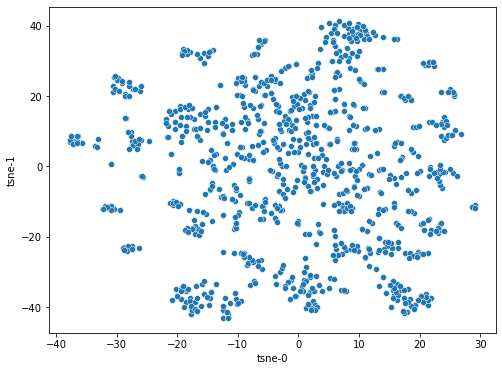

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

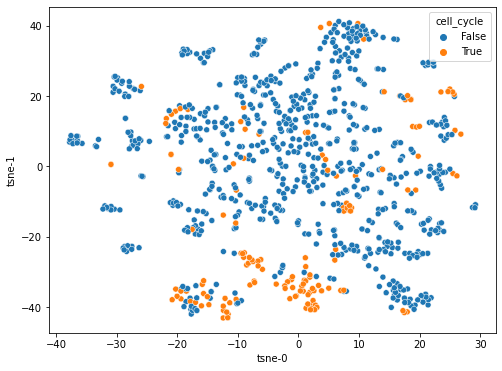

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

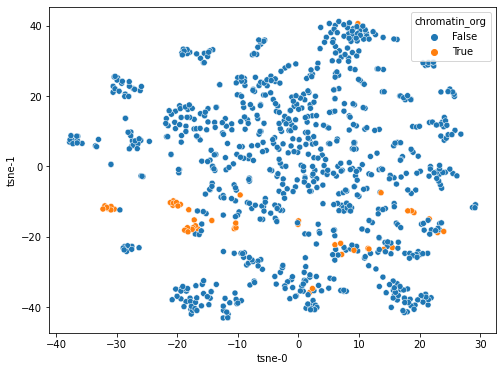

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

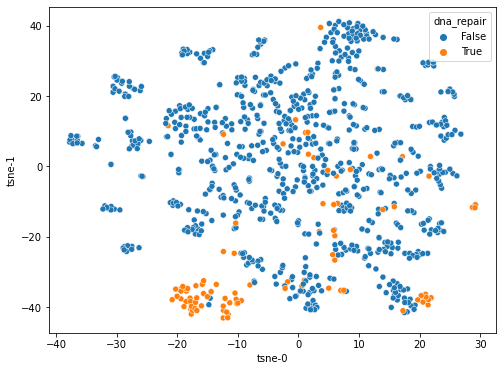

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

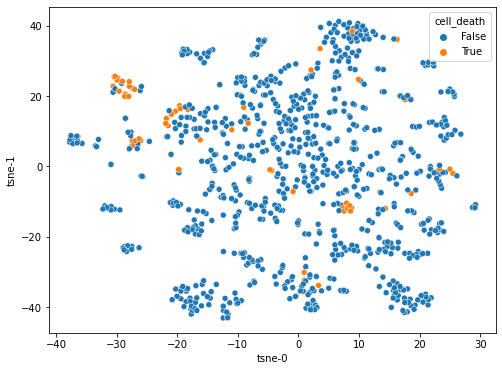

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

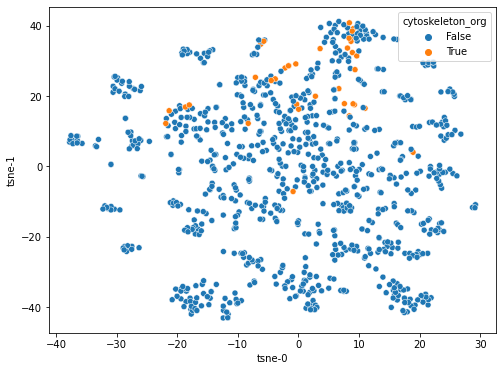

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

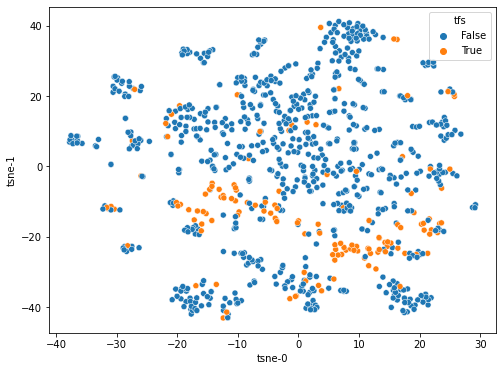

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

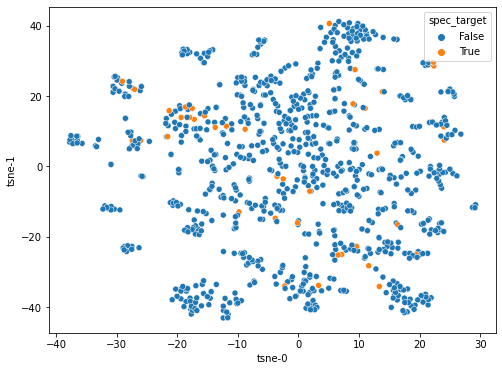

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [37]:
os.makedirs("../../../data/experiments/ppi_embeddings/gae_103121", exist_ok=True)
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_mis_ext_ppi_wo_gex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [38]:
node_feature_key = "sc_gex"
gex_gae = GAE(GCNEncoder(in_channels=1126, hidden_dim=128, out_channels=64))
gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(1126, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [39]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [40]:
gex_gae, loss_hist = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 3.453355550765991
VAL loss: 3.2225594520568848
VAL AUC: 0.6845544713723224 	 AP: 0.6539774334641673
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 3.1564066410064697
VAL loss: 2.817626476287842
VAL AUC: 0.6866621089537124 	 AP: 0.6538230620811614
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 2.928750991821289
VAL loss: 2.671715259552002
VAL AUC: 0.6885430795272165 	 AP: 0.656557357770123
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 2.563352584838867
VAL loss: 2.495650291442871
VAL AUC: 0.6908298571632259 	 AP: 0.6572077065187492
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 2.3612310886383057
VAL loss: 2.2940235137939453
VAL AUC: 0.6937564207085902 	 AP: 0.6582862762117236
------------------------------------------------------------
EPOCH

VAL AUC: 0.7883624771048042 	 AP: 0.7560180427289076
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.12697172164917
VAL loss: 1.2832226753234863
VAL AUC: 0.7895250595000897 	 AP: 0.7575515196910236
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.0836533308029175
VAL loss: 1.2423791885375977
VAL AUC: 0.790687641895375 	 AP: 0.7591560467135519
------------------------------------------------------------
EPOCH 53/300
TRAIN loss: 1.1065244674682617
VAL loss: 1.236438274383545
VAL AUC: 0.7918611920491064 	 AP: 0.7608319290649386
------------------------------------------------------------
EPOCH 54/300
TRAIN loss: 1.0828460454940796
VAL loss: 1.263777494430542
VAL AUC: 0.7930310862833557 	 AP: 0.7624134411632422
------------------------------------------------------------
EPOCH 55/300
TRAIN loss: 1.080011010169983
VAL loss: 1.212451696395874
VAL AUC: 0.7940510878188419 	 AP: 0.7638978580222473
-------------------

VAL loss: 1.1535106897354126
VAL AUC: 0.8210025262403621 	 AP: 0.8038193433029052
------------------------------------------------------------
EPOCH 98/300
TRAIN loss: 1.0055005550384521
VAL loss: 1.1417263746261597
VAL AUC: 0.8215399464042205 	 AP: 0.8045131614966862
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.02496337890625
VAL loss: 1.1626169681549072
VAL AUC: 0.822106613923935 	 AP: 0.8054125975563773
------------------------------------------------------------
EPOCH 100/300
TRAIN loss: 1.0268163681030273
VAL loss: 1.1742727756500244
VAL AUC: 0.8226038189734909 	 AP: 0.8063652285992193
------------------------------------------------------------
EPOCH 101/300
TRAIN loss: 1.0277023315429688
VAL loss: 1.1484706401824951
VAL AUC: 0.8231375832178672 	 AP: 0.8071072544717119
------------------------------------------------------------
EPOCH 102/300
TRAIN loss: 0.9994374513626099
VAL loss: 1.1814661026000977
VAL AUC: 0.8236786593012075 	 AP: 0.

TRAIN loss: 0.9966787099838257
VAL loss: 1.116304874420166
VAL AUC: 0.8379659926369781 	 AP: 0.8286570758734723
------------------------------------------------------------
EPOCH 142/300
TRAIN loss: 1.0022155046463013
VAL loss: 1.1446897983551025
VAL AUC: 0.8382182510812382 	 AP: 0.8290593518825367
------------------------------------------------------------
EPOCH 143/300
TRAIN loss: 0.9747399091720581
VAL loss: 1.1035583019256592
VAL AUC: 0.8384997568813545 	 AP: 0.8294616935422108
------------------------------------------------------------
EPOCH 144/300
TRAIN loss: 0.9688804745674133
VAL loss: 1.1028761863708496
VAL AUC: 0.8388653488295573 	 AP: 0.8298797852357687
------------------------------------------------------------
EPOCH 145/300
TRAIN loss: 0.9771085381507874
VAL loss: 1.1702579259872437
VAL AUC: 0.8392419085362064 	 AP: 0.8304338618177594
------------------------------------------------------------
EPOCH 146/300
TRAIN loss: 0.9775604605674744
VAL loss: 1.1050143241882324
V

VAL loss: 1.0883945226669312
VAL AUC: 0.8524873048195987 	 AP: 0.8527233145173911
------------------------------------------------------------
EPOCH 194/300
TRAIN loss: 0.9683169722557068
VAL loss: 1.1187844276428223
VAL AUC: 0.8527249395859304 	 AP: 0.8532411397880904
------------------------------------------------------------
EPOCH 195/300
TRAIN loss: 0.9472861886024475
VAL loss: 1.1016972064971924
VAL AUC: 0.8528894559626219 	 AP: 0.853794841994634
------------------------------------------------------------
EPOCH 196/300
TRAIN loss: 0.9561590552330017
VAL loss: 1.0892791748046875
VAL AUC: 0.8530832196951694 	 AP: 0.854287892216947
------------------------------------------------------------
EPOCH 197/300
TRAIN loss: 0.9443432688713074
VAL loss: 1.0920549631118774
VAL AUC: 0.8530539723393131 	 AP: 0.8543471229429388
------------------------------------------------------------
EPOCH 198/300
TRAIN loss: 0.9336796402931213
VAL loss: 1.0727183818817139
VAL AUC: 0.8531124670510257 	 AP:

TRAIN loss: 0.926108181476593
VAL loss: 1.0918307304382324
VAL AUC: 0.8583587115077378 	 AP: 0.863493939965031
------------------------------------------------------------
EPOCH 240/300
TRAIN loss: 0.9289660453796387
VAL loss: 1.0939140319824219
VAL AUC: 0.8584537654142704 	 AP: 0.8635388546460311
------------------------------------------------------------
EPOCH 241/300
TRAIN loss: 0.9364765286445618
VAL loss: 1.0825283527374268
VAL AUC: 0.8586292495494079 	 AP: 0.8637457735370472
------------------------------------------------------------
EPOCH 242/300
TRAIN loss: 0.9111031293869019
VAL loss: 1.0767868757247925
VAL AUC: 0.8588376369598836 	 AP: 0.8639725412994681
------------------------------------------------------------
EPOCH 243/300
TRAIN loss: 0.9317498803138733
VAL loss: 1.073577642440796
VAL AUC: 0.8591154868405178 	 AP: 0.8643389926685977
------------------------------------------------------------
EPOCH 244/300
TRAIN loss: 0.9080522656440735
VAL loss: 1.1267122030258179
VAL

VAL loss: 1.1093013286590576
VAL AUC: 0.8644421615258346 	 AP: 0.8735722419973551
------------------------------------------------------------
EPOCH 284/300
TRAIN loss: 0.916843593120575
VAL loss: 1.0906484127044678
VAL AUC: 0.8643306559816326 	 AP: 0.8735625638636677
------------------------------------------------------------
EPOCH 285/300
TRAIN loss: 0.9139766693115234
VAL loss: 1.0797288417816162
VAL AUC: 0.8644129141699782 	 AP: 0.8736908905199383
------------------------------------------------------------
EPOCH 286/300
TRAIN loss: 0.9117498397827148
VAL loss: 1.0658173561096191
VAL AUC: 0.8645299035934033 	 AP: 0.8738138991091322
------------------------------------------------------------
EPOCH 287/300
TRAIN loss: 0.9090806245803833
VAL loss: 1.0634925365447998
VAL AUC: 0.8647931297961093 	 AP: 0.8740418174884234
------------------------------------------------------------
EPOCH 288/300
TRAIN loss: 0.9119709730148315
VAL loss: 1.0908894538879395
VAL AUC: 0.865122162549492 	 AP:

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [41]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [42]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [43]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

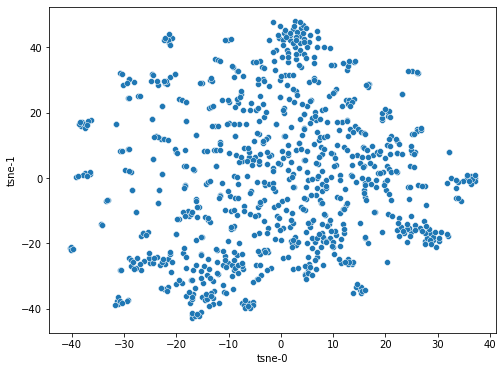

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

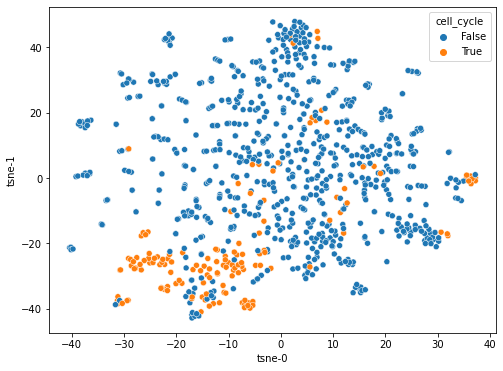

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

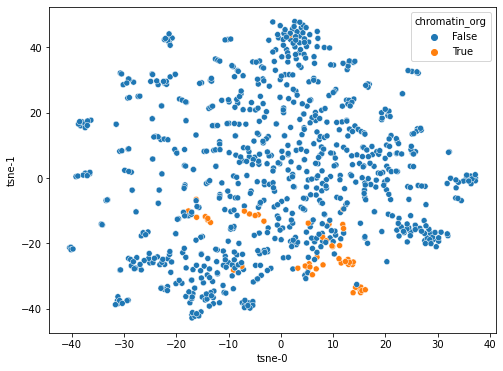

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

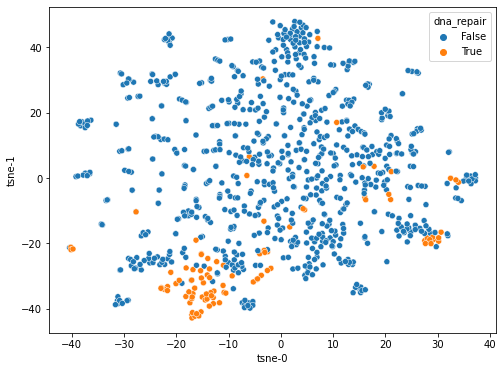

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

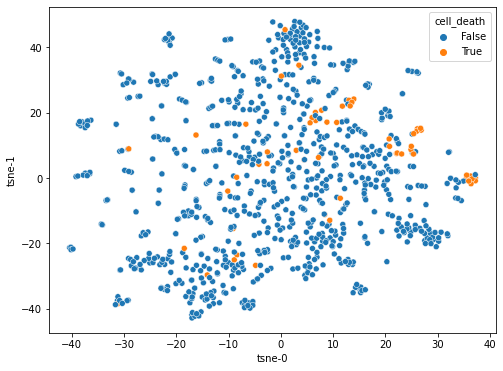

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

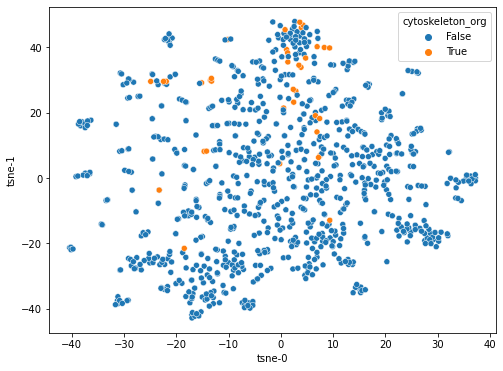

<IPython.core.display.Javascript object>

In [49]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

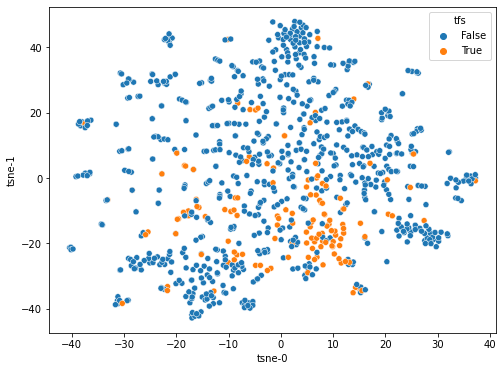

<IPython.core.display.Javascript object>

In [50]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

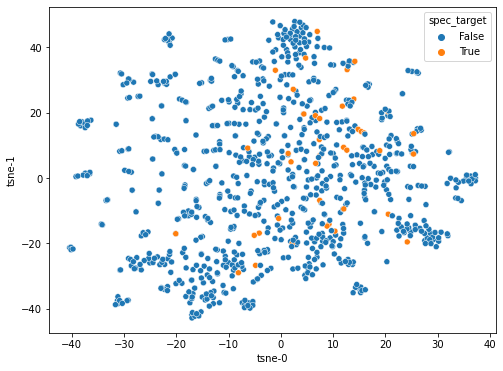

<IPython.core.display.Javascript object>

In [51]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [53]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_mis_ext_ppi_w_scgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [54]:
node_feature_key = "pbulk_gex"
gex_gae = GAE(GCNEncoder(in_channels=3, hidden_dim=128, out_channels=64))
gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(3, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [55]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.001)

<IPython.core.display.Javascript object>

#### Model training

In [56]:
gex_gae, loss_hist = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 1.3288449048995972
VAL loss: 1.3515654802322388
VAL AUC: 0.6558902346734716 	 AP: 0.6352673201052693
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 1.3201918601989746
VAL loss: 1.3468072414398193
VAL AUC: 0.654574103659941 	 AP: 0.6349654273543373
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 1.324263334274292
VAL loss: 1.3488101959228516
VAL AUC: 0.6543547484910193 	 AP: 0.6349731651108826
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 1.3163177967071533
VAL loss: 1.3388546705245972
VAL AUC: 0.654449802397552 	 AP: 0.6337855281669111
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 1.3104172945022583
VAL loss: 1.3517799377441406
VAL AUC: 0.6547861469898988 	 AP: 0.6338851680733364
------------------------------------------------------------
E

VAL loss: 1.3379533290863037
VAL AUC: 0.6929978174160693 	 AP: 0.6631570889348352
------------------------------------------------------------
EPOCH 47/300
TRAIN loss: 1.2529575824737549
VAL loss: 1.3232061862945557
VAL AUC: 0.6936302914864603 	 AP: 0.6644117919559209
------------------------------------------------------------
EPOCH 48/300
TRAIN loss: 1.2610270977020264
VAL loss: 1.3309351205825806
VAL AUC: 0.6944748088868091 	 AP: 0.6655296275347359
------------------------------------------------------------
EPOCH 49/300
TRAIN loss: 1.2501447200775146
VAL loss: 1.2857580184936523
VAL AUC: 0.6951401862325384 	 AP: 0.6663461518354885
------------------------------------------------------------
EPOCH 50/300
TRAIN loss: 1.2630083560943604
VAL loss: 1.3131351470947266
VAL AUC: 0.6957616925444834 	 AP: 0.6669249412456103
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.2504844665527344
VAL loss: 1.3216257095336914
VAL AUC: 0.6967853499994516 	 AP: 0.

TRAIN loss: 1.220380425453186
VAL loss: 1.2871806621551514
VAL AUC: 0.7331909962014996 	 AP: 0.7213036363395708
------------------------------------------------------------
EPOCH 95/300
TRAIN loss: 1.2068772315979004
VAL loss: 1.2636463642120361
VAL AUC: 0.7341013201525248 	 AP: 0.722246227757971
------------------------------------------------------------
EPOCH 96/300
TRAIN loss: 1.2146328687667847
VAL loss: 1.2679470777511597
VAL AUC: 0.7341634707837195 	 AP: 0.722746793596055
------------------------------------------------------------
EPOCH 97/300
TRAIN loss: 1.2162755727767944
VAL loss: 1.286394715309143
VAL AUC: 0.7344778798591739 	 AP: 0.7231525655449402
------------------------------------------------------------
EPOCH 98/300
TRAIN loss: 1.2033929824829102
VAL loss: 1.2648000717163086
VAL AUC: 0.7343170194019646 	 AP: 0.723549321757375
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.2144804000854492
VAL loss: 1.2798223495483398
VAL AUC: 0

TRAIN loss: 1.1828409433364868
VAL loss: 1.268904685974121
VAL AUC: 0.7545817810908533 	 AP: 0.7374947859679707
------------------------------------------------------------
EPOCH 146/300
TRAIN loss: 1.17633056640625
VAL loss: 1.2416390180587769
VAL AUC: 0.751291453557027 	 AP: 0.7334606856520787
------------------------------------------------------------
EPOCH 147/300
TRAIN loss: 1.1730974912643433
VAL loss: 1.2497873306274414
VAL AUC: 0.750318978974807 	 AP: 0.7328808162403269
------------------------------------------------------------
EPOCH 148/300
TRAIN loss: 1.1897692680358887
VAL loss: 1.2536033391952515
VAL AUC: 0.751064786549141 	 AP: 0.7333995923460224
------------------------------------------------------------
EPOCH 149/300
TRAIN loss: 1.1710621118545532
VAL loss: 1.278070092201233
VAL AUC: 0.7539602747789083 	 AP: 0.7371364317216678
------------------------------------------------------------
EPOCH 150/300
TRAIN loss: 1.1828559637069702
VAL loss: 1.246582269668579
VAL AUC:

VAL loss: 1.2550193071365356
VAL AUC: 0.7557187720497645 	 AP: 0.7398609899714435
------------------------------------------------------------
EPOCH 190/300
TRAIN loss: 1.1677138805389404
VAL loss: 1.2490918636322021
VAL AUC: 0.7551045775767834 	 AP: 0.7391247577790493
------------------------------------------------------------
EPOCH 191/300
TRAIN loss: 1.1694729328155518
VAL loss: 1.2675895690917969
VAL AUC: 0.755799202278369 	 AP: 0.7400783683617321
------------------------------------------------------------
EPOCH 192/300
TRAIN loss: 1.167729139328003
VAL loss: 1.2645759582519531
VAL AUC: 0.7584058728690559 	 AP: 0.7426225201813864
------------------------------------------------------------
EPOCH 193/300
TRAIN loss: 1.1663109064102173
VAL loss: 1.2747163772583008
VAL AUC: 0.7606725429479141 	 AP: 0.7457928077051511
------------------------------------------------------------
EPOCH 194/300
TRAIN loss: 1.1720644235610962
VAL loss: 1.2510395050048828
VAL AUC: 0.7607310376596266 	 AP:

TRAIN loss: 1.1753950119018555
VAL loss: 1.2618802785873413
VAL AUC: 0.7588336154484534 	 AP: 0.7441280756403039
------------------------------------------------------------
EPOCH 239/300
TRAIN loss: 1.1612485647201538
VAL loss: 1.270012378692627
VAL AUC: 0.7563366224422273 	 AP: 0.7409809227950956
------------------------------------------------------------
EPOCH 240/300
TRAIN loss: 1.1829198598861694
VAL loss: 1.2620471715927124
VAL AUC: 0.7537482314489505 	 AP: 0.7375878499868189
------------------------------------------------------------
EPOCH 241/300
TRAIN loss: 1.1672465801239014
VAL loss: 1.2702419757843018
VAL AUC: 0.7535252203605467 	 AP: 0.7370823569176115
------------------------------------------------------------
EPOCH 242/300
TRAIN loss: 1.1628526449203491
VAL loss: 1.2657891511917114
VAL AUC: 0.7553458682625974 	 AP: 0.7391732425129445
------------------------------------------------------------
EPOCH 243/300
TRAIN loss: 1.1632170677185059
VAL loss: 1.2545628547668457
V

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [57]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [58]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [59]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

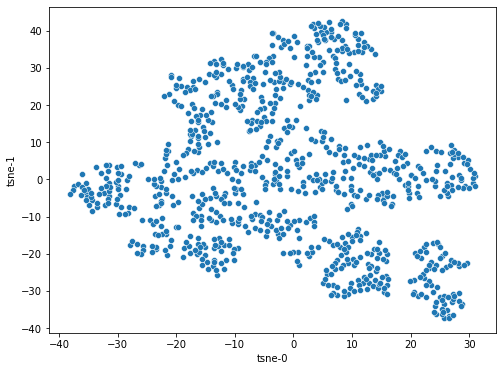

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

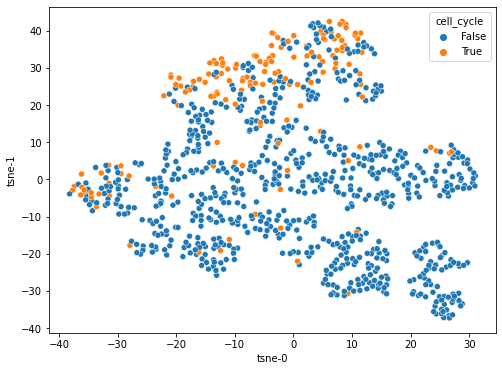

<IPython.core.display.Javascript object>

In [61]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

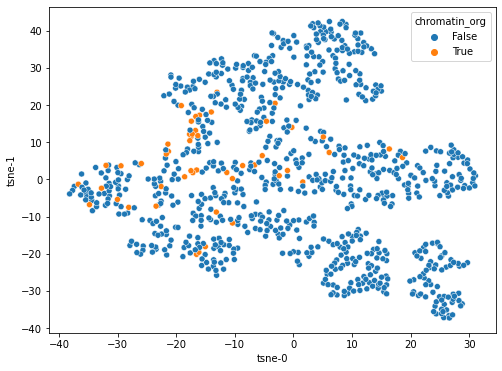

<IPython.core.display.Javascript object>

In [62]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

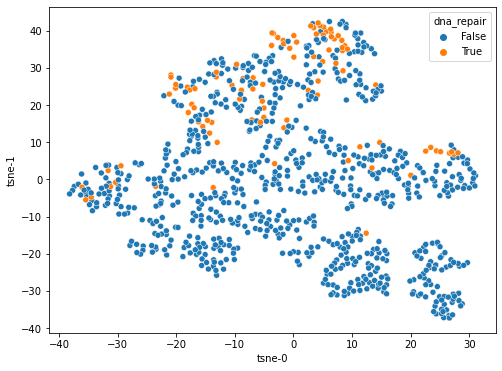

<IPython.core.display.Javascript object>

In [63]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

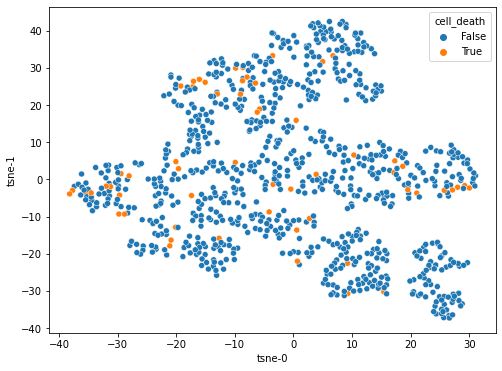

<IPython.core.display.Javascript object>

In [64]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

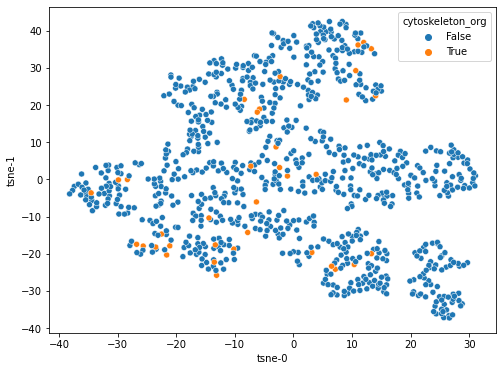

<IPython.core.display.Javascript object>

In [65]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

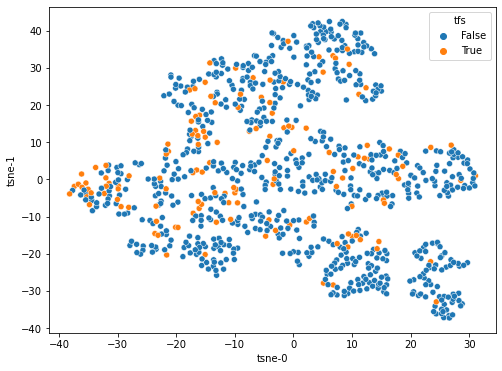

<IPython.core.display.Javascript object>

In [66]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

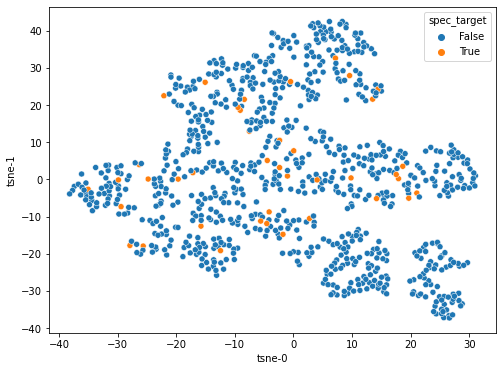

<IPython.core.display.Javascript object>

In [67]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [68]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_mis_ext_ppi_w_pbgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w/o node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [74]:
node_feature_key = "id"
edge_weight_key = "spearmanr_weight"
spearman_gae = GAE(GCNEncoder(in_channels=886, hidden_dim=128, out_channels=64))
spearman_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(886, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [75]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gae.parameters(), lr=0.001)

<IPython.core.display.Javascript object>

#### Model training

In [76]:
spearman_gae, loss_hist = train_gae(
    model=spearman_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 1.3856196403503418
VAL loss: 1.3854784965515137
VAL AUC: 0.7269558255248987 	 AP: 0.676255465900196
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 1.3850748538970947
VAL loss: 1.3848378658294678
VAL AUC: 0.7514797334103513 	 AP: 0.7181300831971812
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 1.384258508682251
VAL loss: 1.3837870359420776
VAL AUC: 0.7664178204139231 	 AP: 0.7470646247888652
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 1.383051872253418
VAL loss: 1.3823564052581787
VAL AUC: 0.7751079410227069 	 AP: 0.7609127303952992
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 1.3812425136566162
VAL loss: 1.3804588317871094
VAL AUC: 0.780231712176771 	 AP: 0.7683031631389458
------------------------------------------------------------
EP

TRAIN loss: 1.151808261871338
VAL loss: 1.2257359027862549
VAL AUC: 0.765140076554954 	 AP: 0.7646044061514166
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.154284954071045
VAL loss: 1.1954139471054077
VAL AUC: 0.7642297526039287 	 AP: 0.7627877166635058
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.1549307107925415
VAL loss: 1.2061405181884766
VAL AUC: 0.7629757722215926 	 AP: 0.7601785725658656
------------------------------------------------------------
EPOCH 53/300
TRAIN loss: 1.1516194343566895
VAL loss: 1.202212929725647
VAL AUC: 0.7618534049406096 	 AP: 0.7581007024277301
------------------------------------------------------------
EPOCH 54/300
TRAIN loss: 1.1411380767822266
VAL loss: 1.2119290828704834
VAL AUC: 0.7611770598364341 	 AP: 0.7566948573752169
------------------------------------------------------------
EPOCH 55/300
TRAIN loss: 1.1482369899749756
VAL loss: 1.238039255142212
VAL AUC: 0

TRAIN loss: 1.1152900457382202
VAL loss: 1.1850265264511108
VAL AUC: 0.787963981881263 	 AP: 0.7901378692754392
------------------------------------------------------------
EPOCH 95/300
TRAIN loss: 1.106925129890442
VAL loss: 1.1866695880889893
VAL AUC: 0.7903695769004384 	 AP: 0.7927236547482568
------------------------------------------------------------
EPOCH 96/300
TRAIN loss: 1.115126371383667
VAL loss: 1.1731746196746826
VAL AUC: 0.7924059240519287 	 AP: 0.7949239986804941
------------------------------------------------------------
EPOCH 97/300
TRAIN loss: 1.108886957168579
VAL loss: 1.179674506187439
VAL AUC: 0.7941827009201949 	 AP: 0.7964409298522608
------------------------------------------------------------
EPOCH 98/300
TRAIN loss: 1.1079645156860352
VAL loss: 1.1869508028030396
VAL AUC: 0.796193456635311 	 AP: 0.798118336086635
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.1082273721694946
VAL loss: 1.1535080671310425
VAL AUC: 0.7

TRAIN loss: 1.0067380666732788
VAL loss: 1.1110419034957886
VAL AUC: 0.8392638440530985 	 AP: 0.8393991744039037
------------------------------------------------------------
EPOCH 140/300
TRAIN loss: 1.0101654529571533
VAL loss: 1.1167116165161133
VAL AUC: 0.8403569639782253 	 AP: 0.8404103919218602
------------------------------------------------------------
EPOCH 141/300
TRAIN loss: 0.9998750686645508
VAL loss: 1.0995404720306396
VAL AUC: 0.8411283629889335 	 AP: 0.8412997367669408
------------------------------------------------------------
EPOCH 142/300
TRAIN loss: 1.0007195472717285
VAL loss: 1.1088430881500244
VAL AUC: 0.8418558909658573 	 AP: 0.8421534043323957
------------------------------------------------------------
EPOCH 143/300
TRAIN loss: 0.9964792728424072
VAL loss: 1.102158784866333
VAL AUC: 0.8423713756128235 	 AP: 0.8428666742485301
------------------------------------------------------------
EPOCH 144/300
TRAIN loss: 1.0066026449203491
VAL loss: 1.1043717861175537
V

VAL AUC: 0.857627527611332 	 AP: 0.8635770193638292
------------------------------------------------------------
EPOCH 190/300
TRAIN loss: 0.9606547355651855
VAL loss: 1.0554829835891724
VAL AUC: 0.8585561311597674 	 AP: 0.8643029791645316
------------------------------------------------------------
EPOCH 191/300
TRAIN loss: 0.9562414288520813
VAL loss: 1.0661484003067017
VAL AUC: 0.859744304991427 	 AP: 0.8651973548732667
------------------------------------------------------------
EPOCH 192/300
TRAIN loss: 0.9317911267280579
VAL loss: 1.116887092590332
VAL AUC: 0.8618062435792913 	 AP: 0.8667534235659663
------------------------------------------------------------
EPOCH 193/300
TRAIN loss: 0.9657197594642639
VAL loss: 1.1025947332382202
VAL AUC: 0.8628628043095978 	 AP: 0.8675621750069553
------------------------------------------------------------
EPOCH 194/300
TRAIN loss: 0.956048846244812
VAL loss: 1.0913820266723633
VAL AUC: 0.8634769987825788 	 AP: 0.8680258223266236
-----------

VAL AUC: 0.8750333602652735 	 AP: 0.8788905411115538
------------------------------------------------------------
EPOCH 239/300
TRAIN loss: 0.9266748428344727
VAL loss: 1.0526912212371826
VAL AUC: 0.8758193829539099 	 AP: 0.879684168950767
------------------------------------------------------------
EPOCH 240/300
TRAIN loss: 0.9157246351242065
VAL loss: 1.0879451036453247
VAL AUC: 0.8766602444347764 	 AP: 0.8803914227672862
------------------------------------------------------------
EPOCH 241/300
TRAIN loss: 0.9287776947021484
VAL loss: 1.0755198001861572
VAL AUC: 0.8770258363829794 	 AP: 0.8806079394111488
------------------------------------------------------------
EPOCH 242/300
TRAIN loss: 0.9199782609939575
VAL loss: 1.0727365016937256
VAL AUC: 0.8767077713880429 	 AP: 0.8806118758179815
------------------------------------------------------------
EPOCH 243/300
TRAIN loss: 0.9301126003265381
VAL loss: 1.0618482828140259
VAL AUC: 0.8762398136943431 	 AP: 0.880030905213379
---------

VAL AUC: 0.8763238998424299 	 AP: 0.8824158206931839
------------------------------------------------------------
EPOCH 288/300
TRAIN loss: 0.8921810388565063
VAL loss: 1.074857234954834
VAL AUC: 0.8765103517360133 	 AP: 0.8826630231064981
------------------------------------------------------------
EPOCH 289/300
TRAIN loss: 0.8995764255523682
VAL loss: 1.0696758031845093
VAL AUC: 0.8770002449466052 	 AP: 0.883102367792683
------------------------------------------------------------
EPOCH 290/300
TRAIN loss: 0.8887750506401062
VAL loss: 1.0611906051635742
VAL AUC: 0.8784004621082225 	 AP: 0.8840320406912898
------------------------------------------------------------
EPOCH 291/300
TRAIN loss: 0.9193534851074219
VAL loss: 1.0572164058685303
VAL AUC: 0.8790987427292902 	 AP: 0.8843896194678508
------------------------------------------------------------
EPOCH 292/300
TRAIN loss: 0.902022123336792
VAL loss: 1.0506117343902588
VAL AUC: 0.878583258082324 	 AP: 0.8839226590818184
-----------

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [77]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [78]:
spearman_gae.eval()
latents = spearman_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [79]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

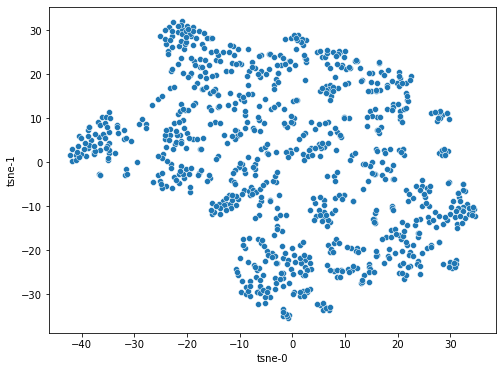

<IPython.core.display.Javascript object>

In [80]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

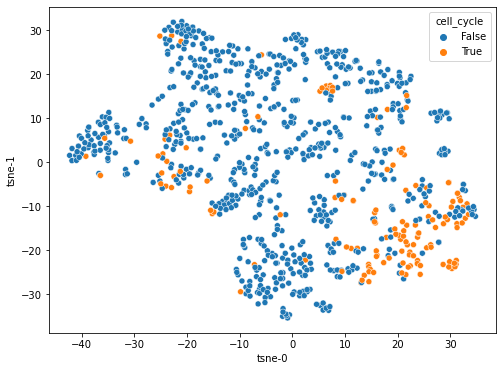

<IPython.core.display.Javascript object>

In [81]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

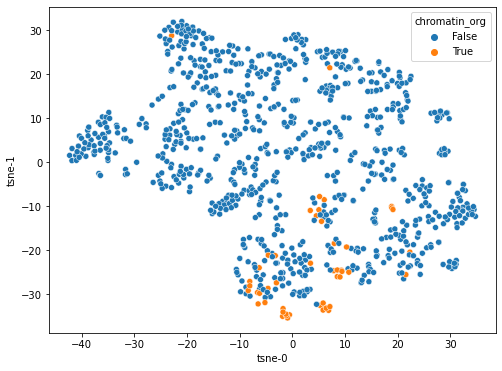

<IPython.core.display.Javascript object>

In [82]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

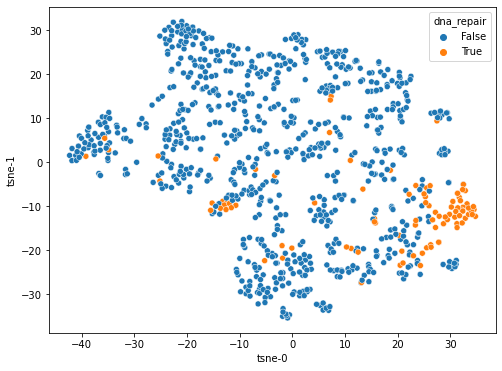

<IPython.core.display.Javascript object>

In [83]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

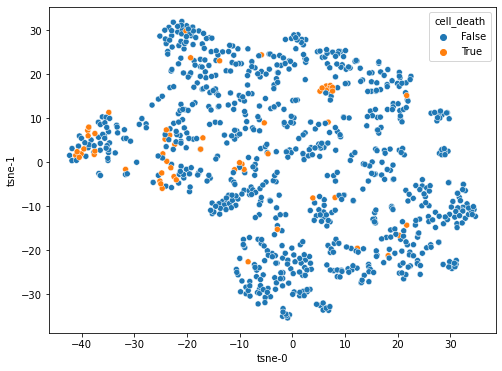

<IPython.core.display.Javascript object>

In [84]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

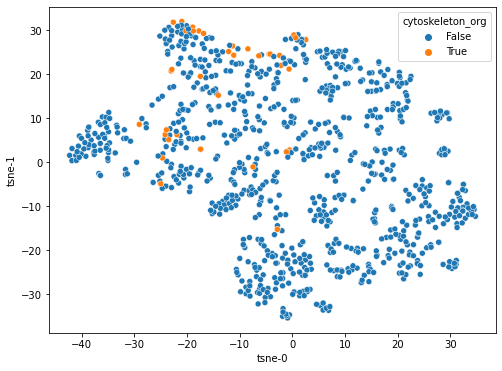

<IPython.core.display.Javascript object>

In [85]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

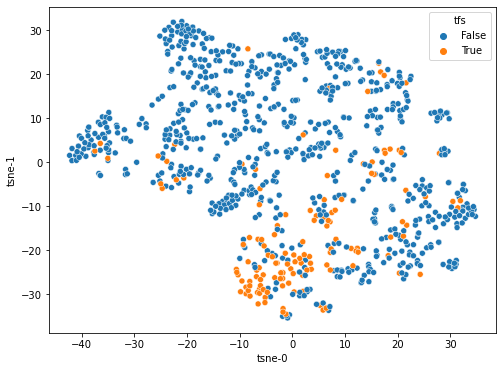

<IPython.core.display.Javascript object>

In [86]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

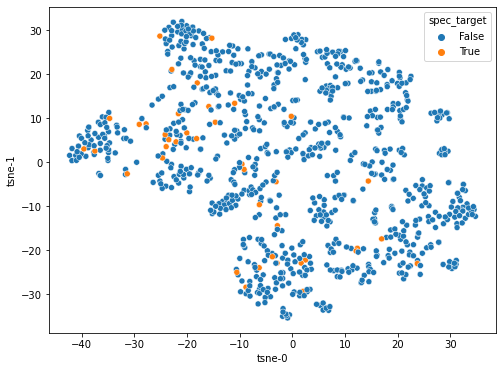

<IPython.core.display.Javascript object>

In [87]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [89]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_mis_ext_ppi_wo_gex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE with GEX node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [90]:
node_feature_key = "sc_gex"
edge_weight_key = "spearmanr_weight"
spearman_gex_gae = GAE(GCNEncoder(in_channels=1126, hidden_dim=128, out_channels=64))
spearman_gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(1126, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [91]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [92]:
spearman_gae, loss_hist = train_gae(
    model=spearman_gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 2.9379053115844727
VAL loss: 2.6505508422851562
VAL AUC: 0.7340793846356328 	 AP: 0.7107871150410007
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 2.6546378135681152
VAL loss: 2.4328296184539795
VAL AUC: 0.7349513214320967 	 AP: 0.7105833959378687
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 2.4239139556884766
VAL loss: 2.262406349182129
VAL AUC: 0.7359457315312086 	 AP: 0.7111476179343589
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 2.1817383766174316
VAL loss: 2.0763587951660156
VAL AUC: 0.7363277751170809 	 AP: 0.7109462110637672
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 2.044766902923584
VAL loss: 1.8666588068008423
VAL AUC: 0.7362619685664044 	 AP: 0.7093369997236187
------------------------------------------------------------


TRAIN loss: 1.0795855522155762
VAL loss: 1.256588339805603
VAL AUC: 0.7950308742400256 	 AP: 0.7785811097750798
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.0660592317581177
VAL loss: 1.2551236152648926
VAL AUC: 0.7961422737625626 	 AP: 0.7802038378566836
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.0876160860061646
VAL loss: 1.2346692085266113
VAL AUC: 0.7970160385187677 	 AP: 0.7813805083155876
------------------------------------------------------------
EPOCH 53/300
TRAIN loss: 1.0787346363067627
VAL loss: 1.2488447427749634
VAL AUC: 0.7980250722958078 	 AP: 0.7826017288351277
------------------------------------------------------------
EPOCH 54/300
TRAIN loss: 1.0843415260314941
VAL loss: 1.2443513870239258
VAL AUC: 0.7989500199247611 	 AP: 0.7838017855297363
------------------------------------------------------------
EPOCH 55/300
TRAIN loss: 1.098128318786621
VAL loss: 1.2337586879730225
VAL AUC

TRAIN loss: 1.0097930431365967
VAL loss: 1.1975570917129517
VAL AUC: 0.8321640484189976 	 AP: 0.8253098834593622
------------------------------------------------------------
EPOCH 98/300
TRAIN loss: 1.0281976461410522
VAL loss: 1.1912442445755005
VAL AUC: 0.8327745869724964 	 AP: 0.8263636653233177
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.0068005323410034
VAL loss: 1.1589595079421997
VAL AUC: 0.8332864156999806 	 AP: 0.8271281872102604
------------------------------------------------------------
EPOCH 100/300
TRAIN loss: 0.9967635869979858
VAL loss: 1.1713985204696655
VAL AUC: 0.8338750187365873 	 AP: 0.8280243316391427
------------------------------------------------------------
EPOCH 101/300
TRAIN loss: 0.9906458854675293
VAL loss: 1.1828280687332153
VAL AUC: 0.8344453421757838 	 AP: 0.8287937357226911
------------------------------------------------------------
EPOCH 102/300
TRAIN loss: 1.0093457698822021
VAL loss: 1.1985204219818115
VA

TRAIN loss: 0.9581888914108276
VAL loss: 1.1492793560028076
VAL AUC: 0.8474567596123264 	 AP: 0.8479045212793566
------------------------------------------------------------
EPOCH 142/300
TRAIN loss: 0.9658204913139343
VAL loss: 1.136521577835083
VAL AUC: 0.8478333193189753 	 AP: 0.8483672181914977
------------------------------------------------------------
EPOCH 143/300
TRAIN loss: 0.9498245120048523
VAL loss: 1.1358211040496826
VAL AUC: 0.8480819218437532 	 AP: 0.8485789492377321
------------------------------------------------------------
EPOCH 144/300
TRAIN loss: 0.9551683664321899
VAL loss: 1.1562848091125488
VAL AUC: 0.8483597717243876 	 AP: 0.8492278630460041
------------------------------------------------------------
EPOCH 145/300
TRAIN loss: 0.9634713530540466
VAL loss: 1.1266499757766724
VAL AUC: 0.8486814926388062 	 AP: 0.849616780314447
------------------------------------------------------------
EPOCH 146/300
TRAIN loss: 0.9551847577095032
VAL loss: 1.152510166168213
VAL

TRAIN loss: 0.9338629245758057
VAL loss: 1.1278200149536133
VAL AUC: 0.8535548333083512 	 AP: 0.8607531372236197
------------------------------------------------------------
EPOCH 188/300
TRAIN loss: 0.9300621747970581
VAL loss: 1.1249651908874512
VAL AUC: 0.853898489739662 	 AP: 0.8612866568727598
------------------------------------------------------------
EPOCH 189/300
TRAIN loss: 0.9381076097488403
VAL loss: 1.1514259576797485
VAL AUC: 0.8543298882385415 	 AP: 0.8617486336181597
------------------------------------------------------------
EPOCH 190/300
TRAIN loss: 0.9390275478363037
VAL loss: 1.1198477745056152
VAL AUC: 0.8548782761608459 	 AP: 0.8625940438978978
------------------------------------------------------------
EPOCH 191/300
TRAIN loss: 0.9327741861343384
VAL loss: 1.1194102764129639
VAL AUC: 0.8552767713843871 	 AP: 0.8630803477848432
------------------------------------------------------------
EPOCH 192/300
TRAIN loss: 0.921360969543457
VAL loss: 1.1154284477233887
VA

VAL AUC: 0.8610275327296191 	 AP: 0.8715655511157492
------------------------------------------------------------
EPOCH 239/300
TRAIN loss: 0.8989958167076111
VAL loss: 1.122772455215454
VAL AUC: 0.8609105433061942 	 AP: 0.8715091687562188
------------------------------------------------------------
EPOCH 240/300
TRAIN loss: 0.8993245959281921
VAL loss: 1.0986487865447998
VAL AUC: 0.8607496828489849 	 AP: 0.8715020200202109
------------------------------------------------------------
EPOCH 241/300
TRAIN loss: 0.8888953924179077
VAL loss: 1.0885121822357178
VAL AUC: 0.8605559191164374 	 AP: 0.8713337508741273
------------------------------------------------------------
EPOCH 242/300
TRAIN loss: 0.8951490521430969
VAL loss: 1.11528480052948
VAL AUC: 0.8601135528591118 	 AP: 0.8710299540516376
------------------------------------------------------------
EPOCH 243/300
TRAIN loss: 0.9075953364372253
VAL loss: 1.0911126136779785
VAL AUC: 0.860000219355169 	 AP: 0.8710867277110748
-----------

TRAIN loss: 0.8985192775726318
VAL loss: 1.0909138917922974
VAL AUC: 0.8642630214712151 	 AP: 0.8788064564950232
------------------------------------------------------------
EPOCH 292/300
TRAIN loss: 0.8827937841415405
VAL loss: 1.071447491645813
VAL AUC: 0.8639888275100629 	 AP: 0.8785974967961208
------------------------------------------------------------
EPOCH 293/300
TRAIN loss: 0.8934326767921448
VAL loss: 1.0913381576538086
VAL AUC: 0.8636853861930545 	 AP: 0.8784583236444369
------------------------------------------------------------
EPOCH 294/300
TRAIN loss: 0.8865387439727783
VAL loss: 1.083986520767212
VAL AUC: 0.8635281816553273 	 AP: 0.8783389876367641
------------------------------------------------------------
EPOCH 295/300
TRAIN loss: 0.8793575167655945
VAL loss: 1.1099140644073486
VAL AUC: 0.8634514073462046 	 AP: 0.8782680074726152
------------------------------------------------------------
EPOCH 296/300
TRAIN loss: 0.8839687705039978
VAL loss: 1.0636200904846191
VA

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [93]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [94]:
spearman_gex_gae.eval()
latents = spearman_gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [95]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

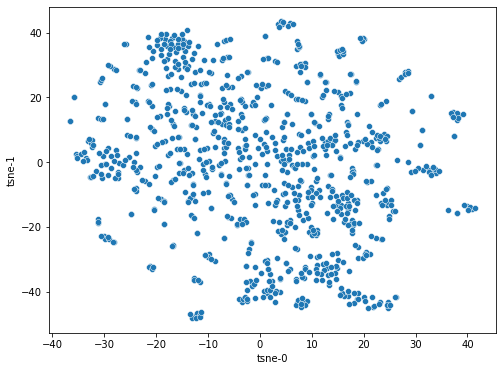

<IPython.core.display.Javascript object>

In [96]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

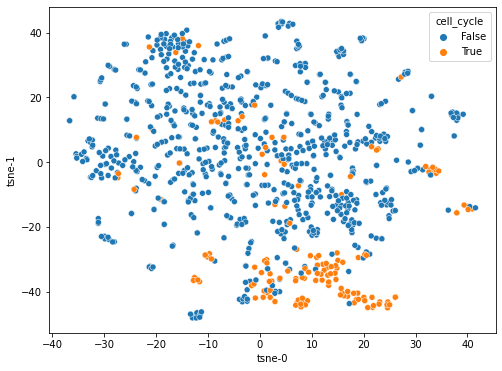

<IPython.core.display.Javascript object>

In [97]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

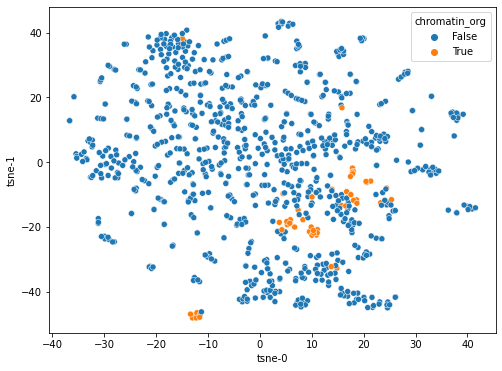

<IPython.core.display.Javascript object>

In [98]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

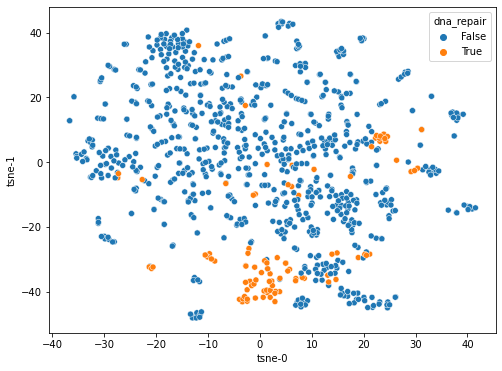

<IPython.core.display.Javascript object>

In [99]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

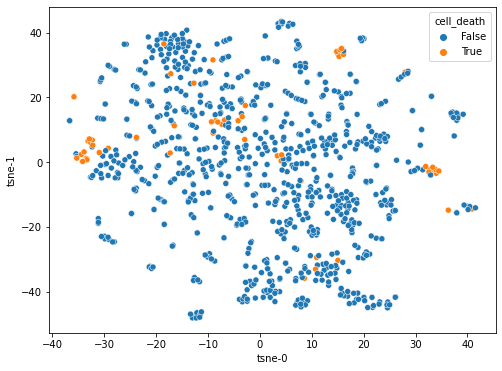

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

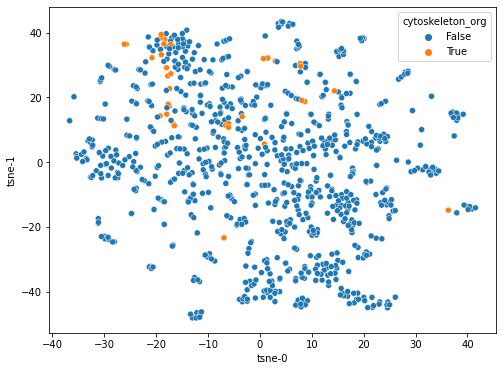

<IPython.core.display.Javascript object>

In [101]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

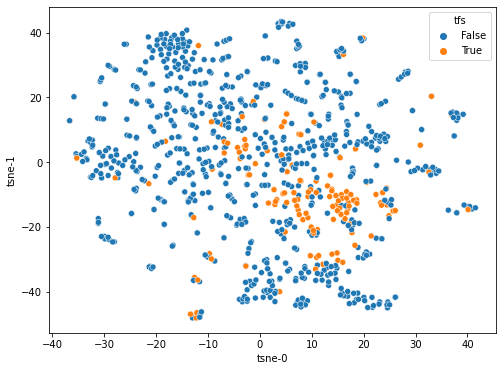

<IPython.core.display.Javascript object>

In [102]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

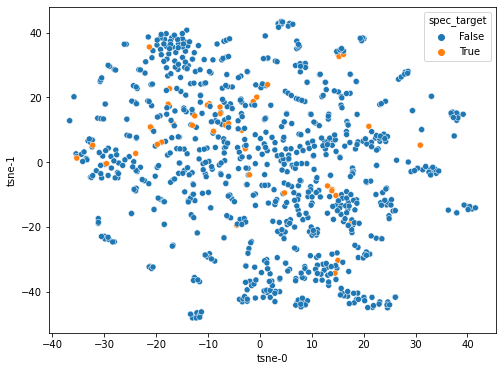

<IPython.core.display.Javascript object>

In [103]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [104]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_mis_ext_ppi_w_scgex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---

## 4. Node2Vec embeddings

An alternative approach for the node embeddings is Node2Vec that learns an embedding that preserves information of the local neighborhood of it. To this end, we run a number of biased random walks and find node embeddings that captures the likelihood of the co-occurence of two nodes in a respective biased random-walk similar to the word2vec model.

To train the model, we sample positive samples that describe a random-walk of pre-defined size on the graph and negative samples which are not based on the graph structure but purely random.

---

### 4.1. DeepWalk w/o edge weights

We will focus for simplicity on the unbiased case of Node2Vec also known as DeepWalk and first will use that each edge in the derived interactome has weight 1.

#### Model definition

We set the length of the random walks to 30 nodes, the context size to 10 nodes and define to run 50 walks per node. For reasons of comparability we set the embedding dimension to 1.

In [105]:
latent_dim = 64
context_size = 10
walks_per_node = 50
walk_length = 30

<IPython.core.display.Javascript object>

In [106]:
n2v_model = Node2Vec(
    graph_data.edge_index,
    embedding_dim=latent_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)
n2v_model.device = device
print(n2v_model)

Node2Vec(886, 64)


<IPython.core.display.Javascript object>

Next, we define the dataloader for a batch size of 128, which corresponds to 128 x 50 x 3 random walks per batch. To speed up the computation we will distribute the computation across 5 different threads. Additionally we define a SparseAdam optimizer to train our model.

In [107]:
batch_size = 128
num_workers = 10

<IPython.core.display.Javascript object>

In [108]:
n2v_loader = n2v_model.loader(
    batch_size=batch_size, shuffle=True, num_workers=num_workers
)
n2v_optimizer = torch.optim.SparseAdam(list(n2v_model.parameters()), lr=0.01)

<IPython.core.display.Javascript object>

#### Model training

We now run the model training once more for 300 epochs, since there is no standardized way to evaluate purely unsupervised token-based embeddings, we will not stop the training early.

In [109]:
def process_single_epoch_n2v(model, optimizer, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(model.device), neg_rw.to(model.device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_n2v_model(model, optimizer, loader, n_epochs=300):
    for i in range(n_epochs):
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        loss = process_single_epoch_n2v(model=model, optimizer=optimizer, loader=loader)
        print("TRAIN loss:", loss)
        print("---" * 30)
    return model

<IPython.core.display.Javascript object>

In [110]:
fitted_n2v_model = train_n2v_model(
    model=n2v_model, optimizer=n2v_optimizer, loader=n2v_loader
)

EPOCH 1/300
TRAIN loss: 6.379678862435477
------------------------------------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 5.604635443006243
------------------------------------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 4.943433080400739
------------------------------------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 4.378625324794224
------------------------------------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 3.891869136265346
------------------------------------------------------------------------------------------
EPOCH 6/300
TRAIN loss: 3.472370113645281
------------------------------------------------------------------------------------------
EPOCH 7/300
TRAIN loss: 3.116635799407959
------------------------------------------------------------------------------------------
EPOCH 8/300
TRAIN loss: 2.814139025551932
---------------------------

TRAIN loss: 1.157555103302002
------------------------------------------------------------------------------------------
EPOCH 63/300
TRAIN loss: 1.1569352831159319
------------------------------------------------------------------------------------------
EPOCH 64/300
TRAIN loss: 1.155240637915475
------------------------------------------------------------------------------------------
EPOCH 65/300
TRAIN loss: 1.1560451303209578
------------------------------------------------------------------------------------------
EPOCH 66/300
TRAIN loss: 1.1545106172561646
------------------------------------------------------------------------------------------
EPOCH 67/300
TRAIN loss: 1.1538641963686262
------------------------------------------------------------------------------------------
EPOCH 68/300
TRAIN loss: 1.1532409872327531
------------------------------------------------------------------------------------------
EPOCH 69/300
TRAIN loss: 1.152541654450553
---------------------------

TRAIN loss: 1.139885084969657
------------------------------------------------------------------------------------------
EPOCH 124/300
TRAIN loss: 1.1398763826915197
------------------------------------------------------------------------------------------
EPOCH 125/300
TRAIN loss: 1.1397803170340401
------------------------------------------------------------------------------------------
EPOCH 126/300
TRAIN loss: 1.1409712859562464
------------------------------------------------------------------------------------------
EPOCH 127/300
TRAIN loss: 1.1393078906195504
------------------------------------------------------------------------------------------
EPOCH 128/300
TRAIN loss: 1.1395719051361084
------------------------------------------------------------------------------------------
EPOCH 129/300
TRAIN loss: 1.1398802655083793
------------------------------------------------------------------------------------------
EPOCH 130/300
TRAIN loss: 1.1409800904137748
------------------

TRAIN loss: 1.137910144669669
------------------------------------------------------------------------------------------
EPOCH 185/300
TRAIN loss: 1.1381506749561854
------------------------------------------------------------------------------------------
EPOCH 186/300
TRAIN loss: 1.1382043872560774
------------------------------------------------------------------------------------------
EPOCH 187/300
TRAIN loss: 1.1382315158843994
------------------------------------------------------------------------------------------
EPOCH 188/300
TRAIN loss: 1.1378816706793649
------------------------------------------------------------------------------------------
EPOCH 189/300
TRAIN loss: 1.138727801186698
------------------------------------------------------------------------------------------
EPOCH 190/300
TRAIN loss: 1.1380046265465873
------------------------------------------------------------------------------------------
EPOCH 191/300
TRAIN loss: 1.1387558323996407
-------------------

TRAIN loss: 1.138723509652274
------------------------------------------------------------------------------------------
EPOCH 246/300
TRAIN loss: 1.1384607894080025
------------------------------------------------------------------------------------------
EPOCH 247/300
TRAIN loss: 1.1380597012383598
------------------------------------------------------------------------------------------
EPOCH 248/300
TRAIN loss: 1.1386604479381017
------------------------------------------------------------------------------------------
EPOCH 249/300
TRAIN loss: 1.137139882360186
------------------------------------------------------------------------------------------
EPOCH 250/300
TRAIN loss: 1.138176339013236
------------------------------------------------------------------------------------------
EPOCH 251/300
TRAIN loss: 1.1378658499036516
------------------------------------------------------------------------------------------
EPOCH 252/300
TRAIN loss: 1.1381001131875175
--------------------

<IPython.core.display.Javascript object>

The loss seems to has converged at 1.105 after training.

#### Visualization of the embeddings

In [111]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [112]:
fitted_n2v_model.eval()
latents = (
    fitted_n2v_model(torch.arange(graph_data.num_nodes, device=device))
    .cpu()
    .detach()
    .numpy()
)

<IPython.core.display.Javascript object>

In [113]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

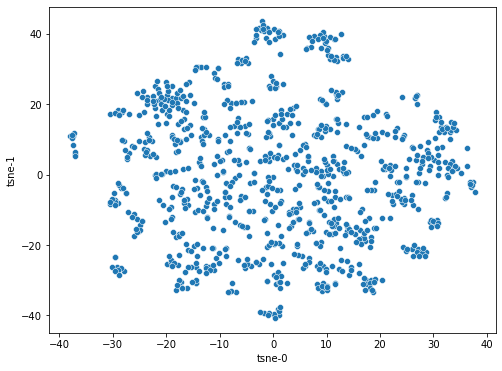

<IPython.core.display.Javascript object>

In [114]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

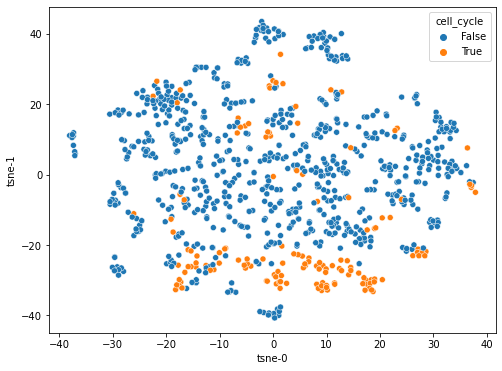

<IPython.core.display.Javascript object>

In [115]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

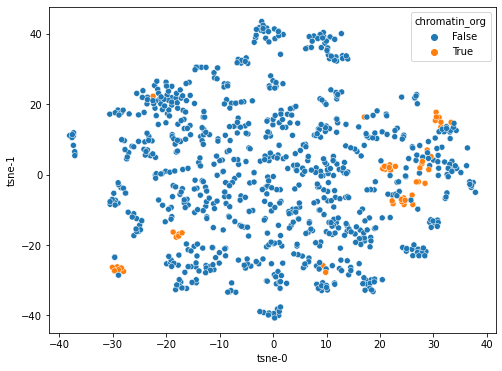

<IPython.core.display.Javascript object>

In [116]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

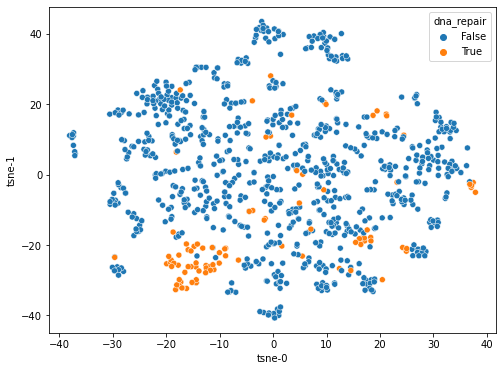

<IPython.core.display.Javascript object>

In [117]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

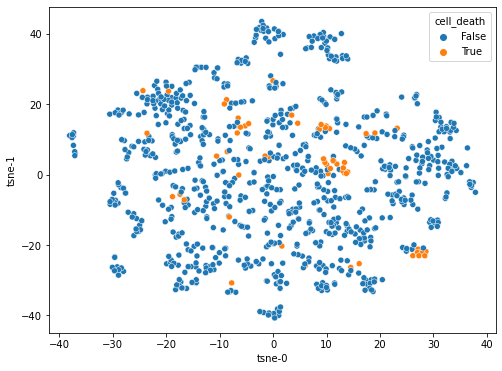

<IPython.core.display.Javascript object>

In [118]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

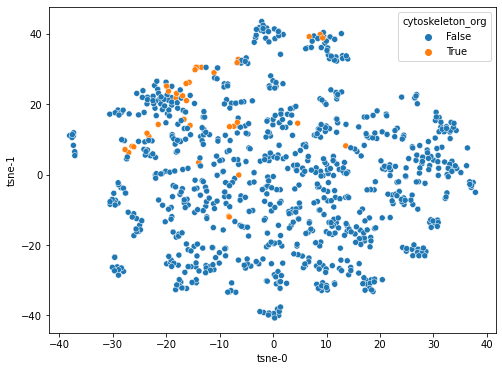

<IPython.core.display.Javascript object>

In [119]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

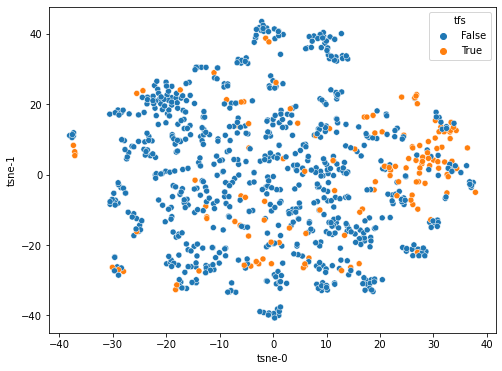

<IPython.core.display.Javascript object>

In [120]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

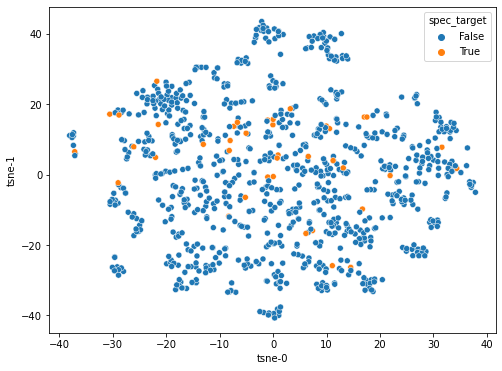

<IPython.core.display.Javascript object>

In [121]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [122]:
file_loc = (
    "../../../data/experiments/ppi_embeddings/gae_103121/n2v_conf_hub_mis_ext_ppi.csv"
)
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>